In [1]:
# Data pre-processing
import pandas as pd
import numpy as np
import datetime as dt

# Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error

#plotting
import matplotlib.pyplot as plt

# Statistical modelling
import scipy
import statsmodels.api as sm

/Users/derrickbakhuis/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Read & Process Data

In [2]:
A = pd.read_csv('ARIMA_A_predictions.csv', encoding='utf-8', sep='\t')
A.drop('Unnamed: 0', inplace=True, axis=1)
A['Acorn'] = 'A'

B = pd.read_csv('ARIMA_B_predictions.csv', encoding='utf-8', sep='\t')
B.drop('Unnamed: 0', inplace=True, axis=1)
B['Acorn'] = 'B'

C = pd.read_csv('ARIMA_C_predictions.csv', encoding='utf-8', sep='\t')
C.drop('Unnamed: 0', inplace=True, axis=1)
C['Acorn'] = 'C'

D = pd.read_csv('ARIMA_D_predictions.csv', encoding='utf-8', sep='\t')
D.drop('Unnamed: 0', inplace=True, axis=1)
D['Acorn'] = 'D'

E = pd.read_csv('ARIMA_E_predictions.csv', encoding='utf-8', sep='\t')
E.drop('Unnamed: 0', inplace=True, axis=1)
E['Acorn'] = 'E'

F = pd.read_csv('ARIMA_F_predictions.csv', encoding='utf-8', sep='\t')
F.drop('Unnamed: 0', inplace=True, axis=1)
F['Acorn'] = 'F'

G = pd.read_csv('ARIMA_G_predictions.csv', encoding='utf-8', sep='\t')
G.drop('Unnamed: 0', inplace=True, axis=1)
G['Acorn'] = 'G'

H = pd.read_csv('ARIMA_H_predictions.csv', encoding='utf-8', sep='\t')
H.drop('Unnamed: 0', inplace=True, axis=1)
H['Acorn'] = 'H'

I = pd.read_csv('ARIMA_I_predictions.csv', encoding='utf-8', sep='\t')
I.drop('Unnamed: 0', inplace=True, axis=1)
I['Acorn'] = 'I'

J = pd.read_csv('ARIMA_J_predictions.csv', encoding='utf-8', sep='\t')
J.drop('Unnamed: 0', inplace=True, axis=1)
J['Acorn'] = 'J'

K = pd.read_csv('ARIMA_K_predictions.csv', encoding='utf-8', sep='\t')
K.drop('Unnamed: 0', inplace=True, axis=1)
K['Acorn'] = 'K'

L = pd.read_csv('ARIMA_L_predictions.csv', encoding='utf-8', sep='\t')
L.drop('Unnamed: 0', inplace=True, axis=1)
L['Acorn'] = 'L'

M = pd.read_csv('ARIMA_M_predictions.csv', encoding='utf-8', sep='\t')
M.drop('Unnamed: 0', inplace=True, axis=1)
M['Acorn'] = 'M'

N = pd.read_csv('ARIMA_N_predictions.csv', encoding='utf-8', sep='\t')
N.drop('Unnamed: 0', inplace=True, axis=1)
N['Acorn'] = 'N'

O = pd.read_csv('ARIMA_O_predictions.csv', encoding='utf-8', sep='\t')
O.drop('Unnamed: 0', inplace=True, axis=1)
O['Acorn'] = 'O'

P = pd.read_csv('ARIMA_P_predictions.csv', encoding='utf-8', sep='\t')
P.drop('Unnamed: 0', inplace=True, axis=1)
P['Acorn'] = 'P'

Q = pd.read_csv('ARIMA_Q_predictions.csv', encoding='utf-8', sep='\t')
Q.drop('Unnamed: 0', inplace=True, axis=1)
Q['Acorn'] = 'Q'

_ = [A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q]
df = pd.concat(_)
df.sort_values(by=['DateTime', 'Acorn'], inplace=True)

del _

In [3]:
holiday = pd.read_csv('holiday.csv', encoding='utf-8', sep='\t')

In [4]:
StdorToU = pd.read_csv('SM_StdorToU.csv', encoding='utf-8', sep='\t')

## Defining Functions

In [5]:
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
def setDates(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month
    df['Day'] = df['DateTime'].dt.day
    df['Hour'] = df['DateTime'].dt.hour
    df['Minute'] = df['DateTime'].dt.minute
    df['Weekday#'] = df['DateTime'].dt.weekday

    df = df[df['Year'] == 2013]
    df['Hour'][df['Minute'] == 30] += .5
    
    df.drop('Minute', inplace=True, axis=1)
    df.drop('DateTime', inplace=True, axis=1)
    
    df.reset_index(inplace=True, drop=True)
    return df

In [7]:
def Seasonality(df):
    # Initialize list for seasons data
    lst_seasons = []
    
    # Append season corresponding to Month number
    for i in range(len(df)):
        if df['Month'].values[i] in [1,2,12]:
            lst_seasons.append('Winter')
        elif df['Month'].values[i] in [3,4,5]:
            lst_seasons.append('Spring')
        elif df['Month'].values[i] in [6,7,8]:
            lst_seasons.append('Summer')
        elif df['Month'].values[i] in [9,10,11]:
            lst_seasons.append('Autumn')
    # Convert list to Pandas DF
    seasons = pd.DataFrame(lst_seasons)
    
    # Merge seasons to df and rename the seasons column to 'Seasons'
    df = pd.concat([df.reset_index(drop=True), seasons.reset_index(drop=True)], axis = 1)
    df.rename(columns={0: 'Season'}, inplace = True)
    
    return df

In [8]:
def isHoliday(df, holiday):
    # Merge dataset while keeping the shape of the original dataset
    df = pd.merge(df, holiday, how='left', on=['Year', 'Month', 'Day'])
    # Fill na's with 0's
    df.fillna(0, inplace=True)
    # Replace holidays with 1
    colnames = list(df.columns.values)
    df = df.values
    # Replace holidays with 1
    for i in range(len(df)):
        if len(str(df[i][-1])) > 1:
            df[i][-1] = 1

    df = pd.DataFrame(data=df, columns=colnames)
    # Rename column Type to isHoliday
    df.rename(columns={'Type': 'isHoliday'}, inplace = True)
    return df

In [9]:
def subset_to_hours(df):
    zero = df[df.Hour == 0]
    zero_30 = df[df.Hour == 0.5]
    one = df[df.Hour == 1]
    one_30 = df[df.Hour == 1.5]
    two = df[df.Hour == 2]
    two_30 = df[df.Hour == 2.5]
    three = df[df.Hour == 3]
    three_30 = df[df.Hour == 3.5]
    four = df[df.Hour == 4]
    four_30 = df[df.Hour == 4.5]
    five = df[df.Hour == 5]
    five_30 = df[df.Hour == 5.5]
    six = df[df.Hour == 6]
    six_30 = df[df.Hour == 6.5]
    seven = df[df.Hour == 7]
    seven_30 = df[df.Hour == 7.5]
    eight = df[df.Hour == 0]
    eight_30 = df[df.Hour == 8.5]
    nine = df[df.Hour == 9]
    nine_30 = df[df.Hour == 9.5]
    ten = df[df.Hour == 10]
    ten_30 = df[df.Hour == 10.5]
    eleven = df[df.Hour == 11]
    eleven_30 = df[df.Hour == 11.5]
    twelve = df[df.Hour == 12]
    twelve_30 = df[df.Hour == 12.5]
    thirteen = df[df.Hour == 13]
    thirteen_30 = df[df.Hour == 13.5]
    fourteen = df[df.Hour == 14]
    fourteen_30 = df[df.Hour == 14.5]
    fifteen = df[df.Hour == 15]
    fifteen_30 = df[df.Hour == 15.5]
    sixteen = df[df.Hour == 16]
    sixteen_30 = df[df.Hour == 16.5]
    seventeen = df[df.Hour == 17]
    seventeen_30 = df[df.Hour == 17.5]
    eighteen = df[df.Hour == 18]
    eighteen_30 = df[df.Hour == 18.5]
    nineteen = df[df.Hour == 19]
    nineteen_30 = df[df.Hour == 19.5]
    twenty = df[df.Hour == 20]
    twenty_30 = df[df.Hour == 20.5]
    twentyone = df[df.Hour == 21]
    twentyone_30 = df[df.Hour == 21.5]
    twentytwo = df[df.Hour == 22]
    twentytwo_30 = df[df.Hour == 22.5]
    twentythree = df[df.Hour == 23]
    twentythree_30 = df[df.Hour == 23.5]

    ds = [zero, zero_30, one, one_30, two, two_30, three, three_30, four, four_30, five, five_30, six, six_30, seven, seven_30,
        eight, eight_30, nine, nine_30, ten, ten_30, eleven, eleven_30, twelve, twelve_30, thirteen, thirteen_30, fourteen, fourteen_30, 
        fifteen, fifteen_30, sixteen, sixteen_30, seventeen, seventeen_30, eighteen, eighteen_30, nineteen, nineteen_30,
       twenty, twenty_30, twentyone, twentyone_30, twentytwo, twentytwo_30, twentythree, twentythree_30]
    return ds

In [10]:
def timeperiod_to_hours(df):
    zero = df[df.Hour == 0]
    zero_30 = df[df.Hour == 0.5]
    one = df[df.Hour == 1]
    one_30 = df[df.Hour == 1.5]
    two = df[df.Hour == 2]
    two_30 = df[df.Hour == 2.5]
    three = df[df.Hour == 3]
    three_30 = df[df.Hour == 3.5]
    four = df[df.Hour == 4]
    four_30 = df[df.Hour == 4.5]
    five = df[df.Hour == 5]
    five_30 = df[df.Hour == 5.5]
    six = df[df.Hour == 6]
    six_30 = df[df.Hour == 6.5]
    seven = df[df.Hour == 7]
    seven_30 = df[df.Hour == 7.5]
    
    ds = [zero, zero_30, one, one_30, two, two_30, three, three_30, four, four_30, five, five_30, 
          six, six_30, seven, seven_30]
    
    return ds

## Data Engineering

In [11]:
df.head()

,DateTime,y_test,y_hat,Acorn
0,2012-12-02 00:00,0.418850,0.383397,A
0,2012-12-02 00:00,0.378600,0.296321,B
0,2012-12-02 00:00,0.218556,0.231067,C
0,2012-12-02 00:00,0.353745,0.410003,D
0,2012-12-02 00:00,0.250101,0.272987,E


In [12]:
df.columns

Index(['DateTime', 'y_test', 'y_hat', 'Acorn'], dtype='object')

In [13]:
df = setDates(df)

/Users/derrickbakhuis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/derrickbakhuis/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:934: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set_with(key, value)
/Users/derrickbakhuis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry po

In [14]:
df = Seasonality(df)
df = pd.get_dummies(df, columns = ['Season'])
df.rename(columns={'Season_Winter': 'isWinter', 'Season_Summer': 'isSummer',
                   'Season_Spring': 'isSpring', 'Season_Autumn': 'isAutumn'}, inplace = True)

In [15]:
df = isHoliday(df, holiday)

In [16]:
# Initialize column with value None
df['TimePeriod'] = 'Peak'
# Implement categories for Time period of the day
df['TimePeriod'][(df['Hour'] >= 8) & (df['Hour'] < 16)] = 'Off-peak'
df['TimePeriod'][(df['Hour'] >= 0) & (df['Hour'] < 8)] = 'Night'

df = pd.get_dummies(df, columns = ['TimePeriod'])
df.rename(columns={'TimePeriod_Night': 'isNight', 'TimePeriod_Off-peak': 'isOff_Peak',
                   'TimePeriod_Peak': 'isPeak'}, inplace=True)

In [17]:
df.head(5)

,y_test,y_hat,Acorn,Year,Month,Day,Hour,Weekday#,isAutumn,isSpring,isSummer,isWinter,Unnamed: 0,isHoliday,isNight,isOff_Peak,isPeak
0,0.52065,0.48695,A,2013,1,1,0,1,0,0,0,1,16,1,1,0,0
1,0.25,0.540648,B,2013,1,1,0,1,0,0,0,1,16,1,1,0,0
2,0.216778,0.270373,C,2013,1,1,0,1,0,0,0,1,16,1,1,0,0
3,0.390196,0.326087,D,2013,1,1,0,1,0,0,0,1,16,1,1,0,0
4,0.221971,0.21942,E,2013,1,1,0,1,0,0,0,1,16,1,1,0,0


In [18]:
hours = sorted(list(set(list(df.Hour))))
print(hours)

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5]


## Overall performance
1. RMSE
2. MAPE

In [19]:
ds = subset_to_hours(df)

In [20]:
err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in ds]

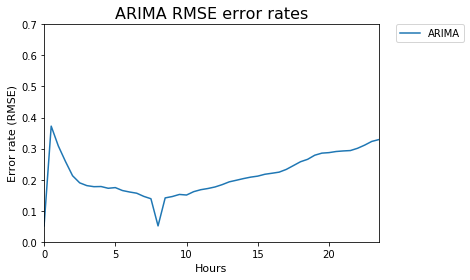

In [21]:
plt.plot(hours, err1, label = 'ARIMA')
plt.axis((0,23.5,0.00,0.7))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (RMSE)', fontsize=11)
plt.title('ARIMA RMSE error rates', fontsize=16)
plt.show()

In [22]:
err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in ds]

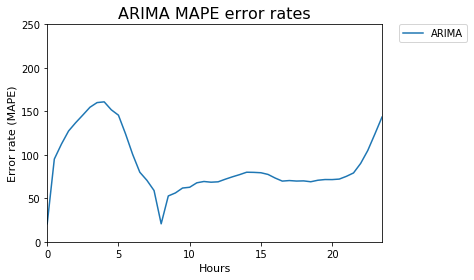

In [23]:
plt.plot(hours, err2, label = 'ARIMA')
plt.axis((0,23.5,0.00,250))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (MAPE)', fontsize=11)
plt.title('ARIMA MAPE error rates', fontsize=16)
plt.show()

In [24]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(df.y_test[df.Acorn == 'A'], df.y_test[df.Acorn == 'B'], df.y_test[df.Acorn == 'C'], 
                            df.y_test[df.Acorn == 'D'], df.y_test[df.Acorn == 'E'], df.y_test[df.Acorn == 'F'], 
                            df.y_test[df.Acorn == 'G'], df.y_test[df.Acorn == 'H'], df.y_test[df.Acorn == 'I'], 
                            df.y_test[df.Acorn == 'J'], df.y_test[df.Acorn == 'K'], df.y_test[df.Acorn == 'L'], 
                            df.y_test[df.Acorn == 'M'], df.y_test[df.Acorn == 'N'], df.y_test[df.Acorn == 'O'], 
                            df.y_test[df.Acorn == 'P'], df.y_test[df.Acorn == 'Q'])
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 4965.072498577638
P-value: 0.0


In [25]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(df.y_hat[df.Acorn == 'A'], df.y_hat[df.Acorn == 'B'], df.y_hat[df.Acorn == 'C'], 
                            df.y_hat[df.Acorn == 'D'], df.y_hat[df.Acorn == 'E'], df.y_hat[df.Acorn == 'F'], 
                            df.y_hat[df.Acorn == 'G'], df.y_hat[df.Acorn == 'H'], df.y_hat[df.Acorn == 'I'], 
                            df.y_hat[df.Acorn == 'J'], df.y_hat[df.Acorn == 'K'], df.y_hat[df.Acorn == 'L'], 
                            df.y_hat[df.Acorn == 'M'], df.y_hat[df.Acorn == 'N'], df.y_hat[df.Acorn == 'O'], 
                            df.y_hat[df.Acorn == 'P'], df.y_hat[df.Acorn == 'Q'])
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 52113.059616473365
P-value: 0.0


## Error by ACORN group

In [26]:
AA = df[(df.Acorn == 'A') | (df.Acorn == 'B') | (df.Acorn == 'C')]
RP = df[(df.Acorn == 'D') | (df.Acorn == 'E')]
CC = df[(df.Acorn == 'F') | (df.Acorn == 'G') | (df.Acorn == 'H') | (df.Acorn == 'I') | (df.Acorn == 'J')]
FS = df[(df.Acorn == 'K') | (df.Acorn == 'L') | (df.Acorn == 'M') | (df.Acorn == 'N')]
UA = df[(df.Acorn == 'O') | (df.Acorn == 'P') | (df.Acorn == 'Q')]

In [27]:
AA = subset_to_hours(AA)
RP = subset_to_hours(RP)
CC = subset_to_hours(CC)
FS = subset_to_hours(FS)
UA = subset_to_hours(UA)

In [28]:
AA_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in AA]
RP_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in RP]
CC_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in CC]
FS_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in FS]
UA_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in UA]

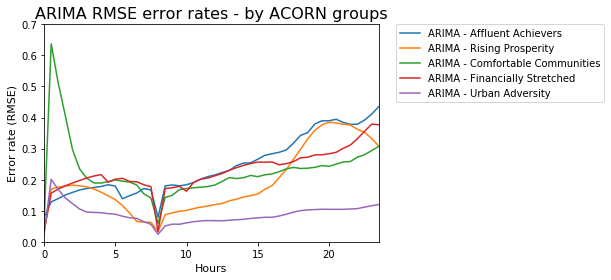

In [29]:
plt.plot(hours, AA_err1, label = 'ARIMA - Affluent Achievers')
plt.plot(hours, RP_err1, label = 'ARIMA - Rising Prosperity')
plt.plot(hours, CC_err1, label = 'ARIMA - Comfortable Communities')
plt.plot(hours, FS_err1, label = 'ARIMA - Financially Stretched')
plt.plot(hours, UA_err1, label = 'ARIMA - Urban Adversity')
plt.axis((0,23.5,0.00,0.7))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (RMSE)', fontsize=11)
plt.title('ARIMA RMSE error rates - by ACORN groups', fontsize=16)
plt.show()

In [30]:
AA_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in AA]
RP_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in RP]
CC_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in CC]
FS_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in FS]
UA_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in UA]

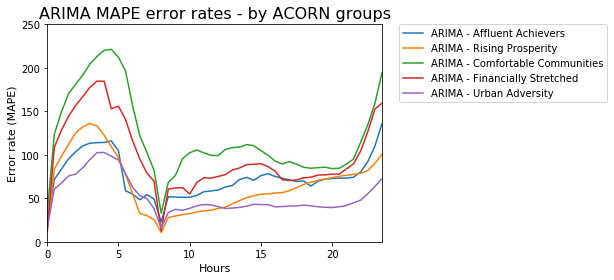

In [31]:
plt.plot(hours, AA_err2, label = 'ARIMA - Affluent Achievers')
plt.plot(hours, RP_err2, label = 'ARIMA - Rising Prosperity')
plt.plot(hours, CC_err2, label = 'ARIMA - Comfortable Communities')
plt.plot(hours, FS_err2, label = 'ARIMA - Financially Stretched')
plt.plot(hours, UA_err2, label = 'ARIMA - Urban Adversity')
plt.axis((0,23.5,0.00,250))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (MAPE)', fontsize=11)
plt.title('ARIMA MAPE error rates - by ACORN groups', fontsize=16)
plt.show()

In [32]:
AA = df[(df.Acorn == 'A') | (df.Acorn == 'B') | (df.Acorn == 'C')]
RP = df[(df.Acorn == 'D') | (df.Acorn == 'E')]
CC = df[(df.Acorn == 'F') | (df.Acorn == 'G') | (df.Acorn == 'H') | (df.Acorn == 'I') | (df.Acorn == 'J')]
FS = df[(df.Acorn == 'K') | (df.Acorn == 'L') | (df.Acorn == 'M') | (df.Acorn == 'N')]
UA = df[(df.Acorn == 'O') | (df.Acorn == 'P') | (df.Acorn == 'Q')]

In [33]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(AA.y_hat, RP.y_hat, CC.y_hat, FS.y_hat, UA.y_hat)
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 15760.782470944894
P-value: 0.0


In [34]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(AA.y_test, RP.y_test, CC.y_test, FS.y_test, UA.y_test)
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 9613.282252139794
P-value: 0.0


## Error by Time-Period

In [35]:
Off_Peak = df[(df['isOff_Peak'] == 1)]
Peak = df[(df['isPeak'] == 1)]
Night = df[(df['isOff_Peak'] == 0) & (df['isPeak'] == 0)]

In [36]:
# Make hours comparable, within the range of 0:00 and 7:30 hours
Off_Peak.Hour = Off_Peak.Hour-8
Peak.Hour = Peak.Hour-16
Night.Hour = Night.Hour

/Users/derrickbakhuis/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [37]:
Off_Peak = timeperiod_to_hours(Off_Peak)
Peak = timeperiod_to_hours(Peak)
Night = timeperiod_to_hours(Night)

In [38]:
Off_Peak_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in Off_Peak]
Peak_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in Peak]
Night_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in Night]

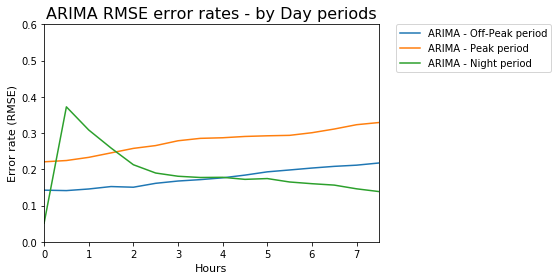

In [39]:
dayperiods = np.arange(0,8,.5)
plt.plot(dayperiods, Off_Peak_err1, label = 'ARIMA - Off-Peak period')
plt.plot(dayperiods, Peak_err1, label = 'ARIMA - Peak period')
plt.plot(dayperiods, Night_err1, label = 'ARIMA - Night period')
plt.axis((0,7.5,0.0,0.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (RMSE)', fontsize=11)
plt.title('ARIMA RMSE error rates - by Day periods', fontsize=16)
plt.show()

In [40]:
Off_Peak_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in Off_Peak]
Peak_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in Peak]
Night_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in Night]

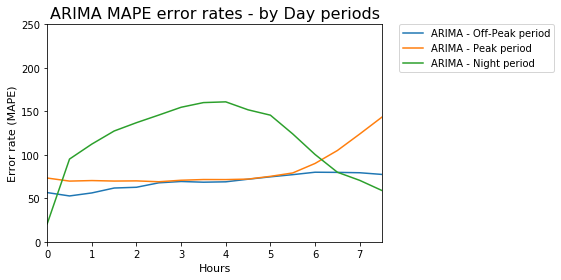

In [41]:
dayperiods = np.arange(0,8,.5)
plt.plot(dayperiods, Off_Peak_err2, label = 'ARIMA - Off-Peak period')
plt.plot(dayperiods, Peak_err2, label = 'ARIMA - Peak period')
plt.plot(dayperiods, Night_err2, label = 'ARIMA - Night period')
plt.axis((0,7.5,0.0,250))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (MAPE)', fontsize=11)
plt.title('ARIMA MAPE error rates - by Day periods', fontsize=16)
plt.show()

In [42]:
Off_Peak = df[(df['isOff_Peak'] == 1)]
Peak = df[(df['isPeak'] == 1)]
Night = df[(df['isOff_Peak'] == 0) & (df['isPeak'] == 0)]

In [43]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(Off_Peak.y_hat, Peak.y_hat, Night.y_hat)
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 690.5857341546819
P-value: 6.915494265731639e-300


In [44]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(Off_Peak.y_test, Peak.y_test, Night.y_test)
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 18636.88581220221
P-value: 0.0


## Error by Season

In [45]:
# Create subsets of seasonal data
Winter = df[(df['isSpring'] == 0) & (df['isWinter'] == 1) & (df['isAutumn'] == 0)]
Summer = df[(df['isSpring'] == 0) & (df['isWinter'] == 0) & (df['isAutumn'] == 0)]
Spring = df[(df['isSpring'] == 1) & (df['isWinter'] == 0) & (df['isAutumn'] == 0)]
Autumn = df[(df['isSpring'] == 0) & (df['isWinter'] == 0) & (df['isAutumn'] == 1)]

In [46]:
Winter = subset_to_hours(Winter)
Summer = subset_to_hours(Summer)
Spring = subset_to_hours(Spring)
Autumn = subset_to_hours(Autumn)

In [47]:
Winter_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in Winter]
Summer_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in Summer]
Spring_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in Spring]
Autumn_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in Autumn]

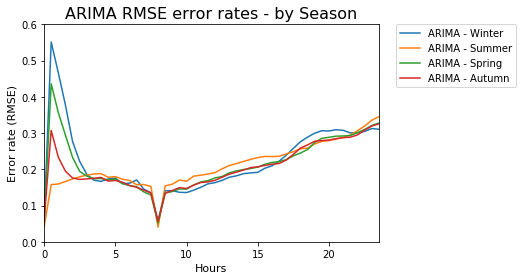

In [48]:
plt.plot(hours, Winter_err1, label = 'ARIMA - Winter')
plt.plot(hours, Summer_err1, label = 'ARIMA - Summer')
plt.plot(hours, Spring_err1, label = 'ARIMA - Spring')
plt.plot(hours, Autumn_err1, label = 'ARIMA - Autumn')
plt.axis((0,23.5,0.00,0.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (RMSE)', fontsize=11)
plt.title('ARIMA RMSE error rates - by Season', fontsize=16)
plt.show()

In [49]:
Winter_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in Winter]
Summer_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in Summer]
Spring_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in Spring]
Autumn_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in Autumn]

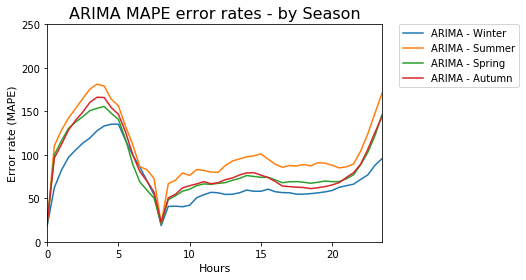

In [50]:
plt.plot(hours, Winter_err2, label = 'ARIMA - Winter')
plt.plot(hours, Summer_err2, label = 'ARIMA - Summer')
plt.plot(hours, Spring_err2, label = 'ARIMA - Spring')
plt.plot(hours, Autumn_err2, label = 'ARIMA - Autumn')
plt.axis((0,23.5,0.00,250))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (MAPE)', fontsize=11)
plt.title('ARIMA MAPE error rates - by Season', fontsize=16)
plt.show()

In [51]:
# Create subsets of seasonal data
Winter = df[(df['isSpring'] == 0) & (df['isWinter'] == 1) & (df['isAutumn'] == 0)]
Summer = df[(df['isSpring'] == 0) & (df['isWinter'] == 0) & (df['isAutumn'] == 0)]
Spring = df[(df['isSpring'] == 1) & (df['isWinter'] == 0) & (df['isAutumn'] == 0)]
Autumn = df[(df['isSpring'] == 0) & (df['isWinter'] == 0) & (df['isAutumn'] == 1)]

In [52]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(Winter.y_hat, Summer.y_hat, Spring.y_hat, Autumn.y_hat)
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 11.195272674699138
P-value: 2.425332855956702e-07


In [53]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(Winter.y_test, Summer.y_test, Spring.y_test, Autumn.y_test)
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 5158.597499897462
P-value: 0.0


## Error by Weekday-Weekend

In [54]:
weekday = df[df['Weekday#'] == 0]
weekend = df[df['Weekday#'] == 1]

In [55]:
weekday = subset_to_hours(weekday)
weekend = subset_to_hours(weekend)

In [56]:
weekday_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in weekday]
weekend_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in weekend]

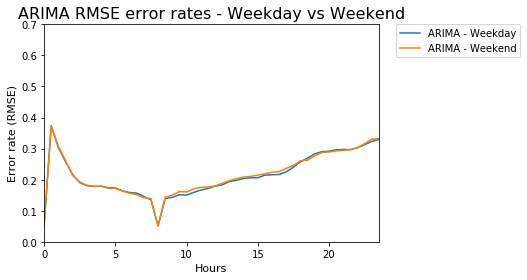

In [57]:
plt.plot(hours, weekday_err1, label = 'ARIMA - Weekday')
plt.plot(hours, weekend_err1, label = 'ARIMA - Weekend')
plt.axis((0,23.5,0.00,0.7))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (RMSE)', fontsize=11)
plt.title('ARIMA RMSE error rates - Weekday vs Weekend', fontsize=16)
plt.show()

In [58]:
weekday_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in weekday]
weekend_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in weekend]

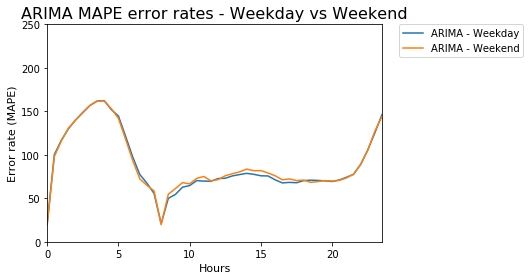

In [59]:
plt.plot(hours, weekday_err2, label = 'ARIMA - Weekday')
plt.plot(hours, weekend_err2, label = 'ARIMA - Weekend')
plt.axis((0,23.5,0.00,250))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (MAPE)', fontsize=11)
plt.title('ARIMA MAPE error rates - Weekday vs Weekend', fontsize=16)
plt.show()

In [60]:
weekday = df[df['Weekday#'] == 0]
weekend = df[df['Weekday#'] == 1]

In [61]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(weekday.loc[:,'y_test'], weekend.loc[:,'y_test'], axis=0, equal_var=True, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: 3.3630867890147527
p-value: 0.0007711341340952269


In [62]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(weekday.loc[:,'y_hat'], weekend.loc[:,'y_hat'], axis=0, equal_var=True, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: -0.1621779962699912
p-value: 0.8711661095348568


## Holiday vs Non-Holiday

In [63]:
holiday = df[df.isHoliday == 1]
non_holiday = df[df.isHoliday == 0]

In [64]:
holiday = subset_to_hours(holiday)
non_holiday = subset_to_hours(non_holiday)

In [65]:
holiday_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in holiday]
non_holiday_err1 = [np.sqrt(mean_squared_error(hour.y_hat, hour.y_test)) for hour in non_holiday]

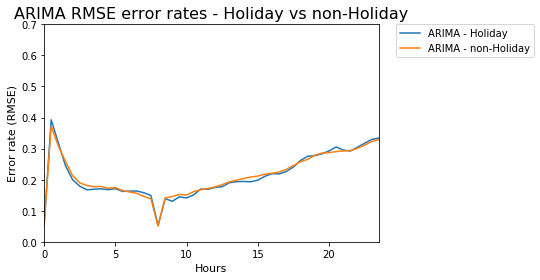

In [66]:
plt.plot(hours, holiday_err1, label = 'ARIMA - Holiday')
plt.plot(hours, non_holiday_err1, label = 'ARIMA - non-Holiday')
plt.axis((0,23.5,0.00,0.7))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (RMSE)', fontsize=11)
plt.title('ARIMA RMSE error rates - Holiday vs non-Holiday', fontsize=16)
plt.show()

In [67]:
holiday_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in holiday]
non_holiday_err2 = [mean_absolute_percentage_error(hour.y_hat, hour.y_test) for hour in non_holiday]

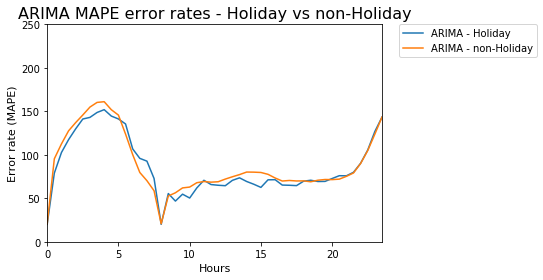

In [68]:
plt.plot(hours, holiday_err2, label = 'ARIMA - Holiday')
plt.plot(hours, non_holiday_err2, label = 'ARIMA - non-Holiday')
plt.axis((0,23.5,0.00,250))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('Error rate (MAPE)', fontsize=11)
plt.title('ARIMA MAPE error rates - Holiday vs non-Holiday', fontsize=16)
plt.show()

In [69]:
holiday = df[df.isHoliday == 1]
non_holiday = df[df.isHoliday == 0]

In [70]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(holiday.loc[:,'y_test'], non_holiday.loc[:,'y_test'], axis=0, equal_var=True, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: 1.6950689421051857
p-value: 0.09006348545655937


In [71]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(holiday.loc[:,'y_hat'], non_holiday.loc[:,'y_hat'], axis=0, equal_var=True, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: -0.5753257680628047
p-value: 0.565071472426651
